# Data Mining Course
## Sharif University of Technology

In this notebook, we are going to analyze tweets and news.
Outline of the project:
* Dataset preparation
* Preprocessing
* Exploration
* Word Collections
* Recommender systems
* Random Walk on graph
* Pixie and simRank algorithms
* PageRank and trustRank
* Stream processing

# Name: Mohammad Mehdi Zare
# Student Number: 

# Section 1: Dataset preparation and preprocessing
In this section:
* Install libraries
* reading datasets
* preprocessing on data

In [ ]:
# installation
!pip install pyspark
!pip install findspark
!pip install networkx
!pip install plotly
!pip install mmh3 
!pip install bitarray

In [2]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("project") \
    .master("local[*]") \
    .getOrCreate()

sc=spark.sparkContext

In [4]:
# libraries
import json
import numpy as np
import matplotlib.pyplot as plt
from itertools import groupby
from operator import itemgetter
from numpy import dot
from numpy.linalg import norm
import random
random.seed(10)
import string
from math import log10
from hazm.utils import stopwords_list
import networkx as nx
from bidi.algorithm import get_display
from arabic_reshaper import reshape
from datetime import datetime
import math 
import mmh3 
from bitarray import bitarray 
from collections import Counter
from random import shuffle 
import hashlib
import statistics


In [5]:
# read data
tweets_rdd = sc.textFile("twitter_data.jsonl")
news_rdd=sc.textFile("news_data2.json")

## news dataset : 

In [6]:
def remove_punc(x):
    punks = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~1234567890۱۲۳۴۵۶۷۸۹۰،؛'
    no_punc = x
    for ch in punks:
      no_punc = no_punc.replace(ch , " ")
    return no_punc.replace("\n" , "").replace("\u200c" , " ")

def remove_stopwords(rdd):
  stopwords = stopwords_list()
  rdd=rdd.replace("های", "").replace("میشود", " ")
  rdd = rdd.split()
  result = [word for word in rdd if not word in stopwords]
  return ' '.join(result)

def clean_rdd_util(T , function):
  T['body'] = function(T['body'])
  T['title'] = T['title'].replace("\u200c", " ")
  if "keywords" in T:
    T['keywords']= [function(x) for x in T['keywords']]
  else:
      T['keywords']=[]
  return T


def cleaning(rdd):
  rdd = rdd.map(lambda x: clean_rdd_util(x , remove_punc))
  rdd = rdd.map(lambda x: clean_rdd_util(x, remove_stopwords))
  return rdd;

In [7]:
news_json_rdd = news_rdd.map(lambda x : json.loads(x))
news_cleaned= cleaning(news_json_rdd)

some properties of news are useful for us. so I keep these properties and remove others.

In [8]:
news_cleaned1= news_cleaned.map(lambda x : (x['uid'],x['body'], x['source'],x['hostname'], datetime.fromtimestamp(x['date_published']).strftime("%m/%d/%Y, %H:%M:%S"), x['keywords'], x['categories']))
news_cleaned1.take(10)

[('68feae4bbbedc2d54adbb2369',
  'سرمربی ملوان تصاویر وایرالی دیدار نساجی پست جالب منتشر گزارش ورزش مهدی تارتار خوشحالی عجیب غریب دقیقه چهره جالب هفته لیگ برتر اختصاص موردتوجه هواداران فوتبال قرار تارتار انتشار پست اینستاگرامی تصاویر جشن خوشحالی نوشته جادوی طرفداران انزلی سرمربی ملوان وعده تیمش ادامه فصل توان خواهد جنگید رضایت هواداران جلب نوشته ادامه میخوانید عکسها نگاه میکنم متحیر میشوم یادم نمیآید هرگز اینطور شوری باشم جادوی شماست سکو آنچنان حس انرژی میدهید لحظه پیروزی برایمان وصفناشدنی سکوها لب خط پای تلویزیونها مستطیل سبز همدل یکصدا میرویم باهم میجنگیم باهم میخندیم هرروز تلاش میکنیم خنده صورت نگه پیروزی شماست مردان نیک چمن مردمان نیک سکو \U0001fa75🤍',
  'ورزش سه',
  'varzesh3.com',
  '10/10/2023, 07:16:46',
  ['سرمربی ملوان', 'لیگ برتر', 'مستطیل سبز', 'انزلی'],
  ['sports']),
 ('434e9837dd761812773fa4627',
  'سخنگوی کمیسیون تلفیق برنامه هفتم توسعه موافقت ضمنی دولت اجرای همسانسازی برنامه خبر گزارش ایلنا محسن زنگنه سخنگوی کمیسیون تلفیق برنامه هفتم توسعه حاشیه علنی امروز سهشنبه مهر م

## tweet dataset

In [9]:
# load json data 
tweets_json_rdd = tweets_rdd.map(lambda x : json.loads(x))
json_formatted_str = json.dumps(tweets_json_rdd.take(1)[0], indent=4)
print(json_formatted_str)

{
    "publish_source": "<a href=\"https://mobile.twitter.com\" rel=\"nofollow\">Twitter Web App</a>",
    "in_reply_to_status_id_str": null,
    "in_reply_to_user_id_str": null,
    "in_reply_to_status_id": null,
    "in_reply_to_user_id": null,
    "in_reply_to_screen_name": null,
    "truncated": false,
    "is_quote_status": true,
    "retweet_count": 32,
    "reply_count": 129,
    "quote_count": 12,
    "favorite_count": 162,
    "favorited": false,
    "retweeted": false,
    "possibly_sensitive": false,
    "lang": "fa",
    "geo": null,
    "view_count": 27433,
    "tweet_type": "quoted",
    "emojis": null,
    "text": "\u067e\u0647\u0644\u0648\u0627\u0646\u200c\u067e\u0647\u0644\u0648\u06cc\u061b \u06cc\u0627\u0631 \u062f\u0648\u0627\u0632\u062f\u0647\u0645 \u062e\u0645\u06cc\u0646\u06cc\u060c \u062e\u0627\u0645\u0646\u0647\u200c\u0627\u06cc \u0648 \u062c.\u0627!\n\n\u0641\u06a9\u0631 \u0645\u06cc\u200c\u06a9\u0646\u06cc\u062f \u0627\u06af\u0631 \u0631\u0636\u0627 \u067e\u06

In [10]:
# In data, some tweets have incomplete data
incomp=tweets_json_rdd.filter(lambda x: x['tweet_type']=="quoted" and x.get('quoted_status').get('id',0)==0).collect()
print("sample of incomplete data: ")
print(incomp[1])
print("number of incomplete data : "+str(len(incomp)))
# filter them
tweets_json_rdd_cleaned=tweets_json_rdd.filter(lambda x:  not (x['tweet_type']=="quoted" and x.get('quoted_status').get('user',0)==0))
tweets_json_rdd_cleaned=tweets_json_rdd_cleaned.filter(lambda x : not x.get('nlp',0)== 0)

sample of incomplete data: 
{'publish_source': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id_str': None, 'in_reply_to_status_id': None, 'in_reply_to_user_id': None, 'in_reply_to_screen_name': None, 'truncated': False, 'is_quote_status': True, 'retweet_count': 1, 'reply_count': 0, 'quote_count': 1, 'favorite_count': 3, 'favorited': False, 'retweeted': False, 'possibly_sensitive': None, 'lang': 'fa', 'geo': None, 'view_count': 235, 'tweet_type': 'quoted', 'emojis': None, 'text': 'ننویسد اقا اون مهریه کوفتی رو تعداد بالا ننویسید!\nاونی که به مهر بالا اصرار داره دیگه به چه زبونی بهتون بگه میخواد بعدا بدبختتون کنه؟\nیا ازدواج نکنید یا از مهر بالا فرار کنید', 'user': {'id': '1363594775539159045', 'id_str': '1363594775539159045', 'created_at': 1613941316, 'name': 'وکیل الرعایا', 'screen_name': 'md_s_law', 'location': 'tehran', 'description': 'حسبنا الله و نعم الوکیل', 'verified': False, 'followers_count': 1124, 'friends_count': 1431, 'listed_count': 1, 'favourites_count': 3955

# Section 2: Exploration
I want to answer below questions: 
* If Twitter decides to verify some users for free, which users are candidates for verifying, and which users are lost their verified label?
* How many distinct words are present in news data? (batch processing and stream processing approach)
* Each user, based on their tweets and behavior on Twitter, is interested in a specific set of categories. News also belongs to various categories. If Twitter intends to suggest daily news to its users, which news does it recommend to each user?
* Plagiarism Detection: Some news agencies copy news from others, which is a form of Plagiarism. I want to identify these instances in the news data.





# question1: PageRank and Trust Rank
To answer this question, I use PageRank and TrustRank algorithms. users are linked to each other by their interaction with tweets. So with the PageRank algorithm, we can find a weight for the user. Also, verified users can be used as trust sets and then use the TrustRank algorithm. I use networkx library.

In [11]:
# find trust set: 
verified_users=tweets_json_rdd_cleaned.filter(lambda x : x['user']['verified']==True).map(lambda x: x['user']['id']).distinct()
verified_users.take(10)

['3345517396',
 '28684404',
 '1518921260360630273',
 '1008316359405637633',
 '770390482929250304',
 '1246111801462456321',
 '947107471985926145',
 '1454596183406510081',
 '1023664436173856770',
 '1392116892274462720']

In [12]:
verified_users.count()

1720

number of users in data

In [13]:
tweets_json_rdd_cleaned.map(lambda x: x['user']['id']).distinct().count()

45873

## make graph

In [14]:
# a function to create (user_id, user_id) as the edge of the graph, in this function I just consider tweets type (replied, generated, retweet, quoted)
def create_triple(x):
    user_id = x['user']['id']
    term=x['tweet_type']
    if term == "replied":
        id_r = x['in_reply_to_user_id']
        return [(user_id, id_r)]
    elif term == "quoted":
        if x.get('quoted_status').get('user',0)!= 0:
            id_q = x['quoted_status']['user']['id']
            return [(user_id, id_q)]
    elif term == "retweeted":
        id_r = x['retweeted_status']['user']['id']
        return[ (user_id, id_r)]

In [15]:
user_edges= tweets_json_rdd_cleaned.filter(lambda x: not x['tweet_type']=="generated").map(lambda x: (create_triple(x)))
edges= user_edges.flatMap(lambda x: x)\
.filter(lambda x: x[0]!=None and x[1]!=None)\
.collect()
edges

[('1180273217795170304', '1180273217795170304'),
 ('1573790732292440064', '1573790732292440064'),
 ('1588121123430047744', '66643970'),
 ('1613170046670606337', '1573418357042331648'),
 ('1249184800721772544', '1074568633970540544'),
 ('1538069861418651650', '1538069861418651650'),
 ('3345517396', '872746395794644992'),
 ('1392087741978972160', '1308413389463527424'),
 ('1498954811840028674', '1317832037735321600'),
 ('1640377983725711362', '970631672268980224'),
 ('1626198440932769793', '97914276'),
 ('3292866378', '605126134'),
 ('1393830037', '1615376642771406851'),
 ('1049384664', '1049384664'),
 ('1081531653409988608', '1592641405222100998'),
 ('68650887', '1519736925837479937'),
 ('1144615631742001154', '884519579770392576'),
 ('18336608', '961134787'),
 ('68650887', '1442155267928428562'),
 ('1181895419347050497', '1680984618755842048'),
 ('1575615647756832768', '334161563'),
 ('1242144662925819910', '1282755153809088512'),
 ('1110999955999580160', '1574856289427296256'),
 ('146

# Page Rank

In [16]:
def pagerank(edges, personal=None, alpha=0.9, library=False):
    if library:
        se= sc.parallelize(edges).map(lambda x: (x[0],[x[1]])).reduceByKey(lambda x,y:x+y).collect()
        link_data=dict(se)
        link_graph = nx.DiGraph(link_data)
        ranks = sc.parallelize(link_data.keys()).map(lambda x : (x, 1.))
        links = sc.parallelize(link_data.items()).cache()
        for iteration in range(10):
            contribs = links.join(ranks).flatMap(computeContribs)
            contribs = links.fullOuterJoin(contribs).mapValues(lambda x : x[1] or 0.0)
            ranks = contribs.reduceByKey(add)
            ranks = ranks.mapValues(lambda rank: rank * 0.85 + 0.15).collect()
    else:
        G = nx.DiGraph()
        G.add_edges_from(edges)
        pr = nx.pagerank(G,personalization=personal, alpha=0.9)
        ranks1=sorted(pr.items(),key=lambda v:(v[1],v[0]),reverse=True)
    if library:
        return ranks
    else:
        return  ranks1


def computeContribs(node_urls_rank):
    _, (urls, rank) = node_urls_rank
    nb_urls = len(urls)
    for url in urls:
        yield url, rank / nb_urls
        from operator import add

In [17]:
G = nx.DiGraph()
G.add_edges_from(edges)
print(G)

DiGraph with 12331 nodes and 13176 edges


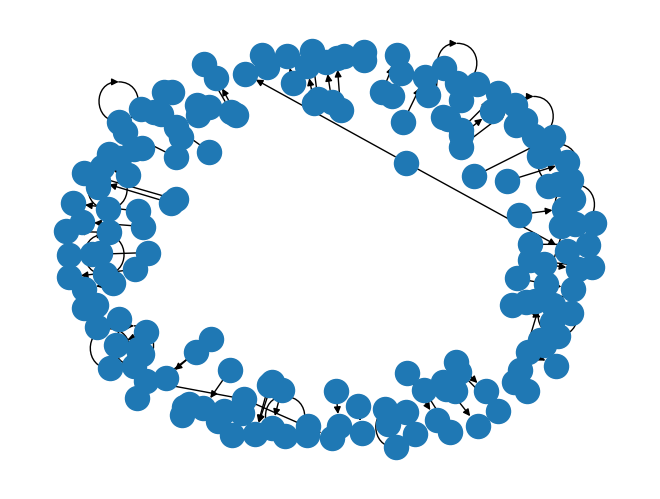

In [18]:
# draw a part of graph
G1 = nx.DiGraph()
G1.add_edges_from(edges[400:500])
nx.draw(G1)

In [19]:
pagerank_sorted=pagerank(edges, alpha=0.9, library=False)
pagerank_sorted

[('38154763', 0.019069219532820137),
 ('2682820352', 0.007503240498135082),
 ('810859229267378176', 0.0059477671465343615),
 ('4075582205', 0.004502849214073731),
 ('1440806264255045638', 0.003923641660580251),
 ('867126568451280896', 0.0036097157626255503),
 ('945886639603310592', 0.002927343671582436),
 ('1612794343911297025', 0.002476016227295738),
 ('2739506010', 0.002474665074495339),
 ('2331584635', 0.002310059354181786),
 ('1408312021', 0.0022640175312704947),
 ('1290359738585288704', 0.0022155140438080757),
 ('1227976819011399681', 0.0019409359004997234),
 ('49127938', 0.0019044675409917117),
 ('46482865', 0.0018732180562105003),
 ('722757627877335040', 0.001818383265052587),
 ('1222773302441148416', 0.00177971144975011),
 ('1057207378637189121', 0.0016337628964365975),
 ('3297594548', 0.0016297538441726407),
 ('2241707204', 0.0016166917367035954),
 ('2221999644', 0.001568975989066674),
 ('1263614720877133825', 0.0015495833807367438),
 ('1298919479003545600', 0.0015304141520736

# Trust Rank

In [20]:
edges_rdd=sc.parallelize(edges)
nodes_list=edges_rdd.map(lambda x : [x[0],x[1]]).flatMap(lambda x:x).distinct().collect()
verified_list=verified_users.collect()
verified_nodes=set(nodes_list).intersection(verified_list)
verified_nodes

{'1002149552974106624',
 '1005185803172106241',
 '1006357946949922816',
 '1008316359405637633',
 '1009843913832718336',
 '1013964115092443136',
 '1015857476342767616',
 '10181662',
 '1021919617',
 '1023664436173856770',
 '102628272',
 '1026857096195788803',
 '1029347598249943040',
 '1029449267180658690',
 '1030009282895536128',
 '1032068910592417793',
 '1032365862',
 '1038042632172257280',
 '1039204088',
 '1041674345926389760',
 '1041981714556432386',
 '1043181897088729088',
 '1046286295746510848',
 '1049942716832993280',
 '1051061858759831553',
 '1052660106637266945',
 '1053580015986765824',
 '1056093629549182976',
 '1056491082568077312',
 '1062546499',
 '1063015132543008768',
 '1063252864213110784',
 '1067156103471882240',
 '1072111767709454338',
 '1074568633970540544',
 '1078152426195173381',
 '1079462649690238977',
 '1086664014044766208',
 '1087611603275649024',
 '1090158040026963968',
 '1092085762558836736',
 '1092094538376773633',
 '109601309',
 '1097842159',
 '109932958236327526

In [21]:
trustset={}
prr=1/len(verified_nodes)
for i in verified_nodes: 
    trustset[i]=prr
trustset

{'1419229136090898434': 0.001145475372279496,
 '818871220104036354': 0.001145475372279496,
 '752660008299409410': 0.001145475372279496,
 '299180876': 0.001145475372279496,
 '1626587655558557697': 0.001145475372279496,
 '762215055995858944': 0.001145475372279496,
 '1327340242584612865': 0.001145475372279496,
 '145157151': 0.001145475372279496,
 '54689640': 0.001145475372279496,
 '1627336002162270209': 0.001145475372279496,
 '1709852344307875840': 0.001145475372279496,
 '5813232': 0.001145475372279496,
 '1021919617': 0.001145475372279496,
 '1655243810799239168': 0.001145475372279496,
 '17788375': 0.001145475372279496,
 '1013964115092443136': 0.001145475372279496,
 '715476553': 0.001145475372279496,
 '49128639': 0.001145475372279496,
 '1252857842': 0.001145475372279496,
 '991910028213972992': 0.001145475372279496,
 '815342626715107332': 0.001145475372279496,
 '990457663103356928': 0.001145475372279496,
 '808471274255220737': 0.001145475372279496,
 '1441755172451934213': 0.0011454753722794

In [22]:
pr1 = nx.pagerank(G,personalization=trustset, alpha=0.9)
pagerank_sorted1=sorted(pr1.items(),key=lambda v:(v[1],v[0]),reverse=True)
pagerank_sorted1

[('38154763', 0.06050678180503591),
 ('49127938', 0.010724595312254231),
 ('2682820352', 0.01015260715102248),
 ('3414505683', 0.00956065942950809),
 ('909512912', 0.008712373671555865),
 ('1227976819011399681', 0.007860097748656215),
 ('1440806264255045638', 0.007367714883802768),
 ('2739506010', 0.006894261694057001),
 ('742451244028039168', 0.006762648959106495),
 ('160940788', 0.006732432143866629),
 ('1458337727536144386', 0.0060065019641884956),
 ('4075582205', 0.005764689497048296),
 ('1408312021', 0.005681094902041521),
 ('1575805035501735936', 0.005270689332861157),
 ('945886639603310592', 0.00517939983047827),
 ('722960833853173760', 0.0050401659163541185),
 ('867126568451280896', 0.005038288959481802),
 ('1535012336670498835', 0.004718221235675369),
 ('2331584635', 0.004538262295900577),
 ('947924373029171200', 0.004237201219407369),
 ('991910028213972992', 0.0041983388413290084),
 ('1298919479003545600', 0.0039863670099147056),
 ('810859229267378176', 0.0038893680409056853)

# compare results to find fake and good users

In [23]:
dict_G1=dict(pagerank_sorted)
dict_G2=dict(pagerank_sorted1)
result_dict = {key: dict_G1[key] - dict_G2[key] for key in dict_G1}
alpha = .03
fake_user = [key for key, value in result_dict.items() if abs(value) > alpha]
fake_user

['38154763']

In [24]:
# fake verified user 
set(verified_nodes).intersection(fake_user)

{'38154763'}

In [25]:
# user that can verify 
first_100_user=list(zip(*pagerank_sorted1))[0][1:100]
new_verified_user=set(first_100_user).difference(verified_nodes)
new_verified_user

{'1065658304884547585',
 '1222773302441148416',
 '1515956552',
 '1588740471546847238',
 '1612794343911297025',
 '2509360928',
 '3189754680',
 '46482865',
 '722757627877335040',
 '802011472964546560',
 '940962097130889216'}

# question2: count distinct words in new data
## Flajolet Martin Algorithm

In [27]:
def get_rightmost_set_bit(n: int) -> int:
    if n == 0:
        return 64
    return int(math.log2(n & -n) + 1) - 1

def get_rightmost_unset_bit(n: int) -> int:
    return get_rightmost_set_bit(~n)

def set_bit(n: int, pos: int) -> int:
    return n | 1 << pos
def generate_random_stream(total_distinct: int):
    values = list(range(total_distinct))
    while True:
        yield random.choice(values)

def count_distinct_true(stream) -> int:
    return len(set(stream))

def hash_fn(m: int, n: int, x: int, 64: int) -> int:
    return (m*x + n) % (2 ** 64)

def leftmost_set_bit_position(n):
    if n == 0:
        return None

    position = 0
    while n:
        position += 1
        n >>= 1

    return position-1

In [28]:
params = []
for i in range(7):
    params.append((2 * random.randint(0, 5) + 1, 2 * random.randint(0, 5) + 1))


def count_distinct_fm(stream,params) -> int:
    estimates = []
    for m, n in params:
        vector, b = 0, 0
        for x in stream:
            y = hash_fn(m, n, x, 64)
            i = get_rightmost_set_bit(y)
            vector = set_bit(vector, i)

        b = leftmost_set_bit_position(vector)
        estimates.append(math.ceil(2 ** b))
    return statistics.median(estimates)

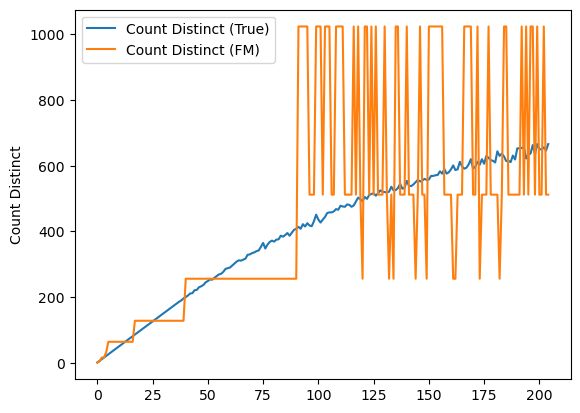

In [29]:

y1, y2 = [], []

total_distincts = range(1, 1024, 5)

for true_distinct in total_distincts:
    stream_gen = generate_random_stream(true_distinct)
    stream = [next(stream_gen) for _ in range(1048)]

    y1.append(count_distinct_true(stream))
    y2.append(count_distinct_fm(stream,params))

plt.ylabel('Count Distinct')
plt.plot(range(len(total_distincts)), y1, label = "Count Distinct (True)")
plt.plot(range(len(total_distincts)), y2, label = "Count Distinct (FM)")
# plt.axes().get_xaxis().set_visible(True)
plt.legend()
plt.show()

In [30]:
tokens=news_cleaned1.flatMap(lambda x :x[1].split()).collect()
part_tokens=np.array_split(tokens, 3)
res=[]
for i in part_tokens:
    tok=list(i)
    tokens_hashed = [int(hashlib.md5(token.encode()).hexdigest(), 16) % (2 ** 64) for token in tok]
    res.append(count_distinct_fm(tokens_hashed,params))    

print(len(tokens), len(set(tokens)))
print("estimated words: ")
print(statistics.mean(res))

1017082 47456
estimated words: 
49152


In [52]:
print(tokens[1:100])

['ملوان', 'تصاویر', 'وایرالی', 'دیدار', 'نساجی', 'پست', 'جالب', 'منتشر', 'گزارش', 'ورزش', 'مهدی', 'تارتار', 'خوشحالی', 'عجیب', 'غریب', 'دقیقه', 'چهره', 'جالب', 'هفته', 'لیگ', 'برتر', 'اختصاص', 'موردتوجه', 'هواداران', 'فوتبال', 'قرار', 'تارتار', 'انتشار', 'پست', 'اینستاگرامی', 'تصاویر', 'جشن', 'خوشحالی', 'نوشته', 'جادوی', 'طرفداران', 'انزلی', 'سرمربی', 'ملوان', 'وعده', 'تیمش', 'ادامه', 'فصل', 'توان', 'خواهد', 'جنگید', 'رضایت', 'هواداران', 'جلب', 'نوشته', 'ادامه', 'میخوانید', 'عکسها', 'نگاه', 'میکنم', 'متحیر', 'میشوم', 'یادم', 'نمیآید', 'هرگز', 'اینطور', 'شوری', 'باشم', 'جادوی', 'شماست', 'سکو', 'آنچنان', 'حس', 'انرژی', 'میدهید', 'لحظه', 'پیروزی', 'برایمان', 'وصفناشدنی', 'سکوها', 'لب', 'خط', 'پای', 'تلویزیونها', 'مستطیل', 'سبز', 'همدل', 'یکصدا', 'میرویم', 'باهم', 'میجنگیم', 'باهم', 'میخندیم', 'هرروز', 'تلاش', 'میکنیم', 'خنده', 'صورت', 'نگه', 'پیروزی', 'شماست', 'مردان', 'نیک', 'چمن']


# question 3 : recommend news to user
In this part I use stream processing. users like some topics. news has topics too. so we can use the bloom filter to recommend news to users each day. 

In [31]:
# save news data on different days to make stream data. 
news_days= news_cleaned.map(lambda x : (x['uid'],x['body'], x['source'],x['hostname'], datetime.fromtimestamp(x['date_published']).strftime("%m/%d/%Y"), x['keywords'], x['categories']))
news_days=news_days.map(lambda x :(x[4],[x])).reduceByKey(lambda x,y : x+y)
news_days.take(1)

[('10/13/2023',
  [('9b4df26294a7a1b48f314ca2c',
    'شبکۀ قدس فلسطین انتشار تصاویری نوزاد شهید فلسطینی آغوش پدر شهیدش قرار میگیرد نوشت هواپیما اشغالگران کودکان نوزادان فلسطینی بمباران میکنند اساس اعلام وزارت بهداشت غزه کودک زن شهدای تجاوز رژیم صهیونیستی غزه',
    'جوان\u200cآنلاين',
    'www.javanonline.ir',
    '10/13/2023',
    ['شبکۀ قدس فلسطین', 'رژیم صهیونیستی', 'غزه', 'فلسطینی'],
    ['economy']),
   ('315e147bc644ed7ec0b25f8e2',
    'سایت کنفدراسیون فوتبال آسیا AFC غیبتی تصمیم مراسم اهدای جوایز سال فوتبال قاره برگزار جایزه جوایز سالانه آسیا نام روز آبان سال فوتبال قاره کهن AFC امروز نامزد معرفی مهدی طارمی بازیکن بینالمللی امین حزباوی بازیکن جوان مسلم اولادقباد سعید احمد عباسی بازیکن فوتسال نامزد جایزه آسیا شدهاند جوایز فدراسیون فوتبال آسیا رئیس فدراسیون قاره کهن رده پایه تقسیم نام فدراسیون ایران دیده اسامی نامزد جوایز سال فوتبال جهان شرح مرد سال فوتبال آسیامتیو لکی باشگاه ملبورن سیتی تیم ملی استرالیا المعز علی باشگاه الدحیل تیم ملی قطر سالم الدوسری باشگاه الهلال تیم ملی عربستان

In [32]:
list_news_day =news_days.collect()

In [33]:

class BloomFilter(object): 
    def __init__(self, items_count, fp_prob): 	
        self.fp_prob = fp_prob 
        self.size = self.get_size(items_count, fp_prob) 
        self.hash_count = self.get_hash_count(self.size, items_count) 
        self.bit_array = bitarray(self.size) 
        self.bit_array.setall(0) 


    
    def add(self, item):       
        digests = [] 
        for i in range(self.hash_count): 

            digest = mmh3.hash(item, i) % self.size 
            digests.append(digest) 

            self.bit_array[digest] = True
    
    def update(self, item): 
        digests = [] 
        self.bit_array.setall(0) 
        for i in range(self.hash_count): 
            digest = mmh3.hash(item, i) % self.size 
            digests.append(digest) 
            self.bit_array[digest] = True

    def check(self, item): 
        
        for i in range(self.hash_count): 
            digest = mmh3.hash(item, i) % self.size 
            if self.bit_array[digest] == False: 

                return False
        return True

    @classmethod
    def get_size(self, n, p): 
        
        m = -(n * math.log(p))/(math.log(2)**2) 
        return int(m) 

    @classmethod
    def get_hash_count(self, m, n): 
        
        k = (m/n) * math.log(2) 
        return int(k) 


In [34]:
# make categories same :
def same_cat(T):
    listt= T['nlp'].get('classification')
    for i in range(0,len(listt)):
        listt[i]=listt[i].replace("sport","sports").replace("cultural","culture").replace("economical","economy").replace("health_care","health")\
        .replace("political","politics")\
        .replace("technology","science_and_technology")
    T['nlp']['classification']=listt
    return T
    
tweets_rdd_ok=tweets_json_rdd_cleaned.filter(lambda x : not x.get('nlp').get('classification',0)==0).map(lambda x :same_cat(x))

In [36]:
# list of categories in new and tweets
categories=news_cleaned1.flatMap(lambda x :x[6]).distinct().collect()
classifications=tweets_rdd_ok.flatMap(lambda x : x['nlp'].get('classification')).distinct().collect()

In [37]:
print(categories)
print(classifications)

['politics', 'social', 'economy', 'security', 'culture', 'sports', 'science_and_technology', 'religious', 'health', 'military']
['entertainment', 'security', 'military', 'health', 'offensive', 'culture', 'religious', 'others', 'politics', 'science_and_technology', 'sports', 'economy', 'personal', 'advertising', 'social']


In [38]:
print(set(categories).intersection(classifications))
print(set(categories).difference(classifications))

{'politics', 'security', 'social', 'health', 'economy', 'sports', 'culture', 'military', 'religious', 'science_and_technology'}
set()


In [57]:
for i in list_news_day:
    print (len(i[1]))

234
2713
90
618
690
169
144
342


In [39]:
# user query for a specific twitter user I recommend news oer day
def recom_news2user(userId, list_news_day, tweets_rdd_ok):
    list_news_day.sort(key=lambda x: x[0])
    classes=tweets_rdd_ok.filter(lambda x : x['user']['id']==userId).flatMap(lambda x : x['nlp'].get('classification')).collect()
    cnt=Counter(classes)
    ll=[]
    for i in set(classes):
        ll.append(cnt[i])
    
    bloomf = BloomFilter(1,.0001)
    print("Size of bit array:{}".format(bloomf.size)) 
    print("False positive Probability:{}".format(bloomf.fp_prob)) 
    print("Number of hash functions:{}".format(bloomf.hash_count)) 
    for i in range(0,len(list_news_day)): 
        ml=random.choices(list(set(classes)), weights=ll, k=1)
        print("category for day "+list_news_day[i][0]+" : "+str(ml))
        for item in ml: 
        	bloomf.update(item) 
        list_news= list_news_day[i][1]
        shuffle(list_news)
        for j in range(0, len(list_news)):
            news_cat=list_news[j][6]
            flag=False
            for word in news_cat:
                if bloomf.check(word):
                    print("in day :"+list_news_day[i][0])
                    print("user "+userId+ "  maybe like news : ")
                    print(list_news[j])
                    flag=True
                    break
            if flag:
                break


In [40]:
recom_news2user('1004052664882118657',list_news_day,tweets_rdd_ok)

Size of bit array:19
False positive Probability:0.0001
Number of hash functions:13
category for day 10/09/2023 : ['politics']
in day :10/09/2023
user 1004052664882118657  maybe like news : 
('0184a2f6b9df84f2203d79f19', 'آنجایی واشنگتن تلاش میکند مانع افزایش قیمت نفت جهان پالایشگاه چین مطمئن صادرات نفت ایران ادامه خواهد گزارش گروه اقتصاد بینالملل فارس نقل بلومبرگ آنجاییکه واشنگتن تلاش میکند مانع افزایش قیمت نفت جهان پالایشگاه چین مطمئن صادرات نفت ایران ادامه خواهد پالایشگاه مستقل چین موسوم تیپاتها مشتاق خرید نفت ایران بلومبرگ مدعی ارتباط ایران حماس ارتباط ادعایی حمله غافلگیرانه میتواند تجارت نفت کشور موضع سختتر آمریکا قبال تحریم ایران معرض تهدید قرار حاضر چندین پالایشگاه تاجر چینی نفت خام ایران میخرند گفتند هیچگونه اختلال سختگیری پیشبینی نمیکنند نخواستند نامشان فاش گفتند فشاری واشنگتن دولت بایدن فشار تورمی آستانه انتخابات ریاستجمهوری سال آینده بررسی خواهد گذشته تحریمها چندان اشتیاق چین خرید نفت ایران تاثیری نداشته چراکه نفت خام مبادی مالزی تامین آمار شرکت رهیابی محموله نفتی نشان خرید ن

# Plagiarism Detection:
Some Twitter users do plagiarism, meaning they send out tweets that are essentially identical to another user's tweet, with slight modifications in sentence structure. Due to constraints in processing tweet text, I implement the algorithm on news data, leveraging the results of Exercise 1 in this section. Additionally, the first news agency to publish the text is considered trustworthy.
note: I implement tf-idf in hw1. to save time I use Mllib library.


In [41]:
from pyspark.mllib.feature import HashingTF, IDF
news_cleaned1.take(10)

[('68feae4bbbedc2d54adbb2369',
  'سرمربی ملوان تصاویر وایرالی دیدار نساجی پست جالب منتشر گزارش ورزش مهدی تارتار خوشحالی عجیب غریب دقیقه چهره جالب هفته لیگ برتر اختصاص موردتوجه هواداران فوتبال قرار تارتار انتشار پست اینستاگرامی تصاویر جشن خوشحالی نوشته جادوی طرفداران انزلی سرمربی ملوان وعده تیمش ادامه فصل توان خواهد جنگید رضایت هواداران جلب نوشته ادامه میخوانید عکسها نگاه میکنم متحیر میشوم یادم نمیآید هرگز اینطور شوری باشم جادوی شماست سکو آنچنان حس انرژی میدهید لحظه پیروزی برایمان وصفناشدنی سکوها لب خط پای تلویزیونها مستطیل سبز همدل یکصدا میرویم باهم میجنگیم باهم میخندیم هرروز تلاش میکنیم خنده صورت نگه پیروزی شماست مردان نیک چمن مردمان نیک سکو \U0001fa75🤍',
  'ورزش سه',
  'varzesh3.com',
  '10/10/2023, 07:16:46',
  ['سرمربی ملوان', 'لیگ برتر', 'مستطیل سبز', 'انزلی'],
  ['sports']),
 ('434e9837dd761812773fa4627',
  'سخنگوی کمیسیون تلفیق برنامه هفتم توسعه موافقت ضمنی دولت اجرای همسانسازی برنامه خبر گزارش ایلنا محسن زنگنه سخنگوی کمیسیون تلفیق برنامه هفتم توسعه حاشیه علنی امروز سهشنبه مهر م

In [42]:
newsId=news_cleaned1.map(lambda x : x[0]).collect()
bodies=news_cleaned1.map(lambda x: x[1])
hashingTF = HashingTF()
tf = hashingTF.transform(bodies)
tf.cache()

PythonRDD[52] at RDD at PythonRDD.scala:53

In [43]:
idf = IDF().fit(tf)
tfidf = idf.transform(tf)

In [44]:
# "0c121ea5f3c89668a74620d8a" is simillar to "e13ce3d66402beff728480ff8" in hw1
candidate=news_cleaned1.filter(lambda x: x[0]=='a58188b693d8167ecf144685a').map(lambda x: x[1])

In [45]:
candidateTf = hashingTF.transform(candidate)
candidateTfIdf = idf.transform(candidateTf).collect()[0]
similarities = tfidf.map(lambda v: v.dot(candidateTfIdf) /
                                   (v.norm(2) * candidateTfIdf.norm(2)))
simil=similarities.collect()

In [46]:
topFive =sorted(tuple(zip(newsId, simil)) , key=lambda v :v[1] ,reverse=True)[0:5]
for t in topFive:
    print("doc '%s' has score %.4f" % (t[0], t[1]))


doc 'a58188b693d8167ecf144685a' has score 1.0000
doc '6789ed5448fe3bcb8e9bf4bcb' has score 0.9947
doc '49a301cb98246ca6d89e33755' has score 0.9947
doc 'c672d416dfda66a9b979e1202' has score 0.9913
doc '35a62bf8c7becf6a2cfca6357' has score 0.9909


In [47]:
x,y=zip(*topFive)
y=list(x)
top_news=news_cleaned1.filter(lambda x: x[0] in y)
top_news.take(10)

[('a58188b693d8167ecf144685a',
  'مراسم افتتاح ایستگاه مترو خطوط آغاز عملیات حفاری مکانیزه تونل خط حضور رئیسجمهور انجام گزارشحوزه دولت خبرگزاری تسنیم سید ابراهیم رئیسی رئیسجمهور صبح امروز سهشنبه حضور ایستگاه شهید آرمان علیوردی منطقه کوهسار افتتاح رسمی ایستگاه خط مترو تهران قطار ایستگاه شهران ایستگاه شکل رسمی افتتاح مراسم افتتاح ایستگاه شهید علیوردی حضور خانواده برگزار رئیس جمهور پیشنهاد تابلویی زندگینامه شهید والامقام ورودی ایستگاه نصب همزمان مراسم ایستگاه شهر زیبا خط میدان کتاب خط متروی تهران بهرهبرداری رسیدند مراسم امروز عملیات حفاری مکانیزه تونل خط متروی تهران کارگاه دریاچه شهدای خلیج فارس آغاز خط شرق پایتخت ادامه مییابد خط کیلومتر ایستگاه جابجایی مسافران مناطق پوشش خواهد',
  'خبرگزاری تسنیم',
  'www.tasnimnews.com',
  '10/10/2023, 07:33:10',
  ['کارگاه دریاچه شهدای خلیج فارس',
   'ایستگاه شهید آرمان علی وردی',
   'ایستگاه شهید علی وردی',
   'ایستگاه شهران'],
  ['politics']),
 ('35a62bf8c7becf6a2cfca6357',
  'گزارش خبرگزاری مهر حجت الاسلام سید ابراهیم رئیسی رئیسجمهور صبح امروز سهشنب

In [50]:
top_news.map(lambda x : (x[0],x[4])).take(10)

[('a58188b693d8167ecf144685a', '10/10/2023, 07:33:10'),
 ('35a62bf8c7becf6a2cfca6357', '10/10/2023, 07:46:15'),
 ('6789ed5448fe3bcb8e9bf4bcb', '10/10/2023, 07:48:02'),
 ('49a301cb98246ca6d89e33755', '10/10/2023, 08:21:00'),
 ('c672d416dfda66a9b979e1202', '10/10/2023, 09:06:22')]

In [59]:
top_news.filter(lambda x: x[0]=='a58188b693d8167ecf144685a').map(lambda x:(x[2],x[3])).collect()

[('خبرگزاری تسنیم', 'www.tasnimnews.com')]